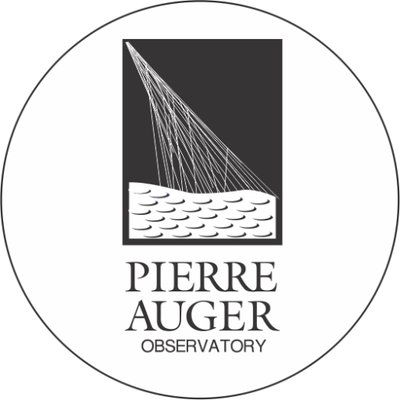

# Weather correction of the energy estimator

<i>Notebook released together with the Pierre Auger Observatory Open Data release 2021 (<a href="https://doi.org/10.5281/zenodo.4487612">DOI 10.5281/zenodo.4487612</a>). More information at the <a href="https://opendata.auger.org/">Auger Open Data website</a>.</i>

Atmospheric effects on the development of extensive air showers can be understood in terms of local changes in atmospheric parameters. Changes in the atmospheric pressure lead to changes in the rates of the recorded showers. When the pressure rises, there is more material for the cosmic rays to cross and so the detected rate falls. At fixed pressure, if the temperature increases, the particles in the shower will spread out more as the distance travelled between each scattering rises. This effect is described by the Molière radius which is thus a function both of temperature and pressure. This radius has a mean value of ~90 m at the Auger Observatory and defines the spread of the electrons in the showers. Changes in the bulk properties of the atmosphere such as air pressure, temperature, and humidity, have a significant effects on the rate of nitrogen fluorescence emission, as well as on light transmission.
<p>
In this notebook we show how the energy assignment can be corrected to account for such atmospheric effects. The value of the calculated correction is then compared with that contained in the Pierre Auger Observatory Open Data, where it is referred as 'wcorr'.
 </p>

The atmospheric effects on the energy reconstruction are described in [A. Aab et al 2017 JINST 12 P02006](https://iopscience.iop.org/article/10.1088/1748-0221/12/02/P02006) ,  [arXiv](https://arxiv.org/abs/1702.02835).


## Notebook setup

Importing of some python packages and the definition of some default settings is required.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

from collections import namedtuple
import datetime
import pytz

In [2]:
# Plotting
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.ticker as mticker

# Default values for plots
plt.rcParams["figure.figsize"] = [14, 9] # figure width and height
plt.rcParams["font.size"] = 4

plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=18

plt.rcParams['xtick.major.size']=10
plt.rcParams['xtick.minor.size']=6
plt.rcParams['ytick.major.size']=10
plt.rcParams['ytick.minor.size']=6



# Jupyter/ IPython formatting
from IPython.display import Math, Latex, display

## Local time conversion
We define a function to set local time at the Observatory:

In [3]:
#set Malargue timezone to convert Unix time in local time
malargue_tz = pytz.timezone('America/Argentina/Mendoza') # UTC-3

def read_ws(fn, utc=False):
    df = pd.read_csv(fn)
    date = pd.to_datetime(df.time.values, unit='s', utc=True)
    if utc:
        date = pd.to_datetime(df.time.values, unit='s', utc=True)
    else:
        date = pd.to_datetime(df.time.values, unit='s', utc=True).tz_convert(malargue_tz)
    df.set_index(date, inplace=True)
    return df

## Read data
We define a function to open and read the data:

In [4]:
# Data loading, encapsulated to make it less installation and OS dependant
import os.path
from zipfile import ZipFile
def AugerOpen(fdir, file):
    """
    Loads a file from the auger open data release. Can be either in the local directory,
    in the parent directory or in the augeropendata directory.
    File is identified by it directory *fdir* and filename *file* and can be found in the directory
    or in a zip file.
    """
    for loc in [".", "..", "augeropendata", "data"]:
        fname = os.path.join(loc, fdir, file)
        if os.path.isfile(fname):
            return open(fname)
        zname=os.path.join(loc, fdir + ".zip")
        if os.path.isfile(zname):
            with ZipFile(zname) as myzip:
                return myzip.open(os.path.join(fdir, file))
    raise FileNotFoundError(os.path.join(fdir, file))


We upload the data summary file as a Panda dataframe for easy handling subsequently:

In [5]:
#import weather station data as dataframes
wsData = read_ws(AugerOpen("weatherStations", "weather.csv"))
#display first 10 entries
wsData.head(10)

,time,temperature,pressure,density,density2HoursBefore
2003-12-31 21:05:00-03:00,1072915500,19.91,864.9,1.028,1.025
2003-12-31 21:10:00-03:00,1072915800,19.75,864.9,1.028,1.026
2003-12-31 21:15:00-03:00,1072916100,19.50,864.9,1.029,1.027
2003-12-31 21:20:00-03:00,1072916400,19.25,864.9,1.029,1.028
2003-12-31 21:25:00-03:00,1072916700,19.18,864.9,1.029,1.028
2003-12-31 21:30:00-03:00,1072917000,19.05,864.9,1.030,1.028
2003-12-31 21:35:00-03:00,1072917300,19.20,864.9,1.030,1.028
2003-12-31 21:40:00-03:00,1072917600,19.35,864.9,1.030,1.027
2003-12-31 21:45:00-03:00,1072917900,19.12,864.9,1.030,1.028
2003-12-31 21:50:00-03:00,1072918200,18.95,864.9,1.030,1.029


In [6]:
gps_utc_leapseconds = pd.Timedelta(seconds=18) # from the beginning of the GPS epoch to now
gps_epoch = pd.Timestamp('1980-01-06') - gps_utc_leapseconds

In [7]:
#import cosmic-rays data as dataframes

df = pd.read_csv(AugerOpen("summary", "dataSummary.csv"))
df = df[df.sdStandard==1]
df['utctime'] = df.gpstime + gps_epoch.timestamp()
df.set_index('id', inplace=True, drop=False)

In [8]:
df.head(10)

,id,sdid,gpstime,sdStandard,multiEye,sd_gpsnanotime,sd_theta,sd_dtheta,sd_phi,sd_dphi,...,fd_minViewAngle,fd_uspL,fd_duspL,fd_uspR,fd_duspR,fd_hottestStationId,fd_distSdpStation,fd_distAxisStation,sd_exposure,utctime
id,,,,,,,,,,,,,,,,,,,,,
40034054600,40034054600,622240,757206958,1,0,226346000.0,18.89,0.96,33.54,1.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2157,1.073172e+09
40184443900,40184443900,634230,758506851,1,0,972896000.0,49.25,0.21,85.90,0.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6125,1.074472e+09
40202296800,40202296800,635890,758658180,1,0,638367000.0,12.44,0.97,106.58,3.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7782,1.074623e+09
40224091700,40224091700,638260,758848929,1,0,238387000.0,54.83,0.27,335.25,0.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0469,1.074814e+09
40300846100,40300846100,646220,759507673,1,0,902280000.0,38.05,0.38,320.20,0.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.8571,1.075472e+09
40342062100,40342062100,650050,759865433,1,0,68323000.0,58.41,0.35,73.92,0.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.4112,1.075830e+09
40353663900,40353663900,651210,759967851,1,0,785292000.0,39.01,0.41,31.28,0.61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5795,1.075933e+09
40406048600,40406048600,656590,760423698,1,0,44676000.0,53.04,0.27,242.80,0.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.2932,1.076388e+09
40431561500,40431561500,658340,760638027,1,0,75580000.0,50.37,0.50,82.43,0.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5058,1.076603e+09


## Calculation of the weather correction

For each reconstructed shower-event, the signals S at the reference distance from the shower axis of 1000 m, S(1000), obtained from the ﬁt to the lateral dis
tribution of the signals measured in the individual water Cherenkov detectors, are expected to be modulated according to:

$$
S = S_0[1+\alpha_P (P-P_0) + \alpha_ρ (ρ_d-ρ_0)+\beta_ρ(ρ̃  - ρ_d)]
$$

where P<sub>0</sub> and ρ<sub>0</sub> are reference values for pressure and air-density corresponding to averages at the site of the Pierre Auger Observatory measured over the years of operation. S<sub>0</sub> is the value of the signal that would have been obtained at those reference atmospheric conditions, ρ<sub>d</sub> is the daily average of the density (within ±12 h of the event) while P and ρ are the actual pressure and density determined at ground level at the time of the event, and ρ̃is the density that was determined two hours before. The coeﬃcients α<sub>P</sub> , α<sub>ρ</sub> and β<sub>ρ</sub> parameterize the assumed linear dependence of the signal modulation.



In [9]:
refP = 861.742  # reference values for pressure P_0 
refRho = 1.05435 # reference values for air density ρ_0

The diﬀerential ﬂux of cosmic rays per unit solid angle is assumed to follow a power law E<sub>t</sub><sup>−γ</sup> , with E<sub>t</sub> the
true energy of the cosmic rays. The spectral index is taken here as γ = 3.29,
as determined by the Pierre Auger Observatory in [ [DOI: https://doi.org/10.22323/1.236.0271]](https://pos.sissa.it/cgi-bin/reader/contribution.cgi?id=PoS(ICRC2015)271) at energies below ∼ 5 EeV.<br>
The dependence of the signal on the atmospheric conditions leads to a
modulation of the rate R of recorded events.
For the assumed cosmic-ray energy spectrum with the shape of a power-law, the relation between the rate coeﬃcients and the signal ones is a<sub>P,ρ</sub> = B(γ −1)α<sub>P,ρ</sub> and similarly b<sub>ρ</sub> = B(γ − 1)β<sub>ρ</sub> . The coeﬃcient B is derived from the energy calibration and is equal to B = 1.023 ± 0.006 for the SD of the Observatory.

To determine the atmospheric coeﬃcients we compute the rate by counting the events in one hour bins and normalizing to the corresponding area of
the array at that time, which is calculated from the total number of hexagons
of active neighboring detectors, which is known at every second.
The expected number of events in bin *i* is given by:

$$µ_i = R_0 × A_i × C_i$$

where R<sub>0</sub> is the average rate that would have been observed if the atmospheric parameters were always the reference ones, and C is the correction that we are going to calculate:

$$C_i = 1 + a_P (P_i − P_0 ) + a_ρ (ρ _{d_i} − ρ_0 ) + b_ρ (ρ̃ _i − ρ_{d_i} )$$

In [10]:
weather_interp = interp1d(wsData.time, wsData[['pressure', 'density', 'density2HoursBefore']].transpose())

In [11]:
rateConv = 1.023 * (3.29 - 1) #B(gamma - 1):conversion between rate parameters (a, b) and signal ones (alpha, beta)

We define the correction function

In [12]:
def correctionFunction(gps , zenith):
    '''
    parametrization of atmospheric coefficients as a function of sinus of the zenith angle
    '''
    pressure, density, density2HoursBefore = weather_interp(gps)

    x = pow(np.sin(np.radians(zenith)),2)
    alphaP = (2.1e-3 - x * 2.6e-2 + x * x *2.6e-2) / rateConv  
    alphaRho = (-2.7 + x * 1.5 + x*x*2.2)/rateConv
    betaRho = (-1.0 + x *1.2)/rateConv
    corr = 1 + alphaP * (pressure - refP) + alphaRho * (density - refRho) + betaRho*(density2HoursBefore - density)
    return 1/corr 

We calculate the correction for a specific event

In [13]:
#calculate the correction for a specific event 
dfSel = df.loc[40431561500] #(e.g id==0431561500)
#dfSel = df.loc[182426706400] #(e.g id==182426706400)

corr = np.round(correctionFunction(dfSel.utctime, dfSel.sd_theta), 3)

Finally we compare the calculated correction to the tabulated value:

In [14]:
#compare correction values
print("Event id:", dfSel.id)
print("calculated correction:",corr)
print("tabulated correction:", dfSel.sd_wcorr)


Event id: 40431561500.0
calculated correction: 0.983
tabulated correction: 0.983
